# Introduccción

En este notebook vamos a implementar una árbol de regresión para compararlo con una regresión linear simple. 

Para este ejercicio utilizaremos el data set de [Fish Market](https://www.kaggle.com/aungpyaeap/fish-market?select=Fish.csv), el cual contiene información sobre los pescados a la venta en un mercado. Los features son los siguientes:

* *Species*: que los indica a la especie que pertenece el pescado
* *Weight*: peso en gramos
* *Length1*: longitud vertical en cms
* *Length2*: longitud diagonal en cms
* *Length3*: longitud cruzada en cms
* *Height*: altura en cms
* *Width*: anchura

Para este caso, usaremos el peso como el feature que queremos predecir y el cual trataremos como nuestra variable dependiente (aunque esto no necesariamente sea cierto).

Las librerías que utilizamos son:

* **Numpy** que tiene precargadas funciones para manejar vectores y matrices.
* **Pandas** que nos permite trabajar con matrices como tablas.
* **Seaborn** y **Matplotlib** para visualizar datos.
* **Scikit-Learn** con el que armaremos un pequeño modelo de machine learning usando regresión logística.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

Empezamos abriendo el data set con la función load_dataset para visualizar nuestro data frame.

In [ ]:
df = pd.read_csv("Fish.csv")
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


Con la función *info* podemos ver los tipos de datos que usamos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


Con la función *describe* podemos ver la información estadística básica.

In [ ]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


# Análisis Exploratorio de Datos

En este punto conviene hacer sentido de nuestros datos y ver que tenemos a la mano. Uno de los análisis más rápidos que podemos hacer es calculando coeficientes de correlación. Esto lo podemos hacer con la función *corr* de Pandas y luego aplicando un *heatmap* de Seaborn. 

Nota importante: el método *corr* sin parámetros calcula correlaciones de Pearson, la cual se centra en la dependencia lineal. Si deseamos buscar otro tipo de correlaciones, podemos indicarselo como *method* seguido de la correlación que busquemos. Esta puede también ser de Kendall (asociación ordinal) o de Spearman (correlación entre variables aleatorias).

<AxesSubplot:>

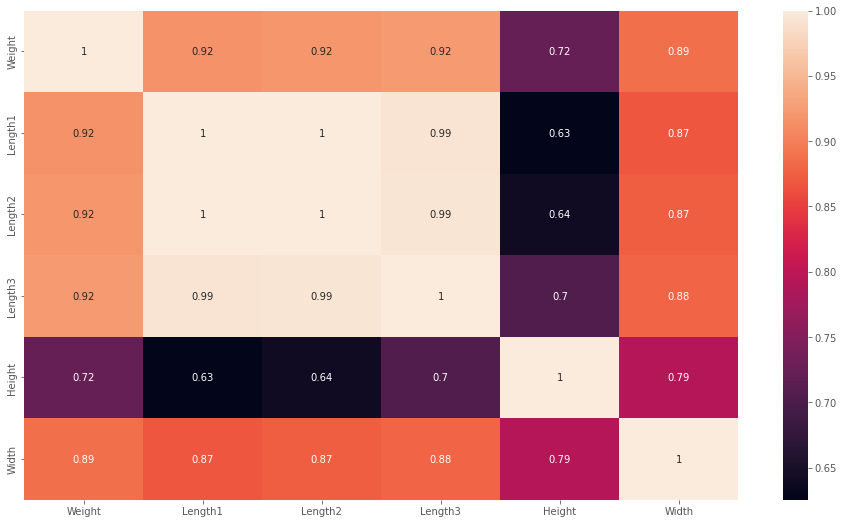

In [ ]:
corr = df.corr()
sns.heatmap(corr, annot = True, yticklabels=corr.columns, xticklabels=corr.columns)

Una forma de visualizar esto es aplicando un *pairplot* de Seaborn 

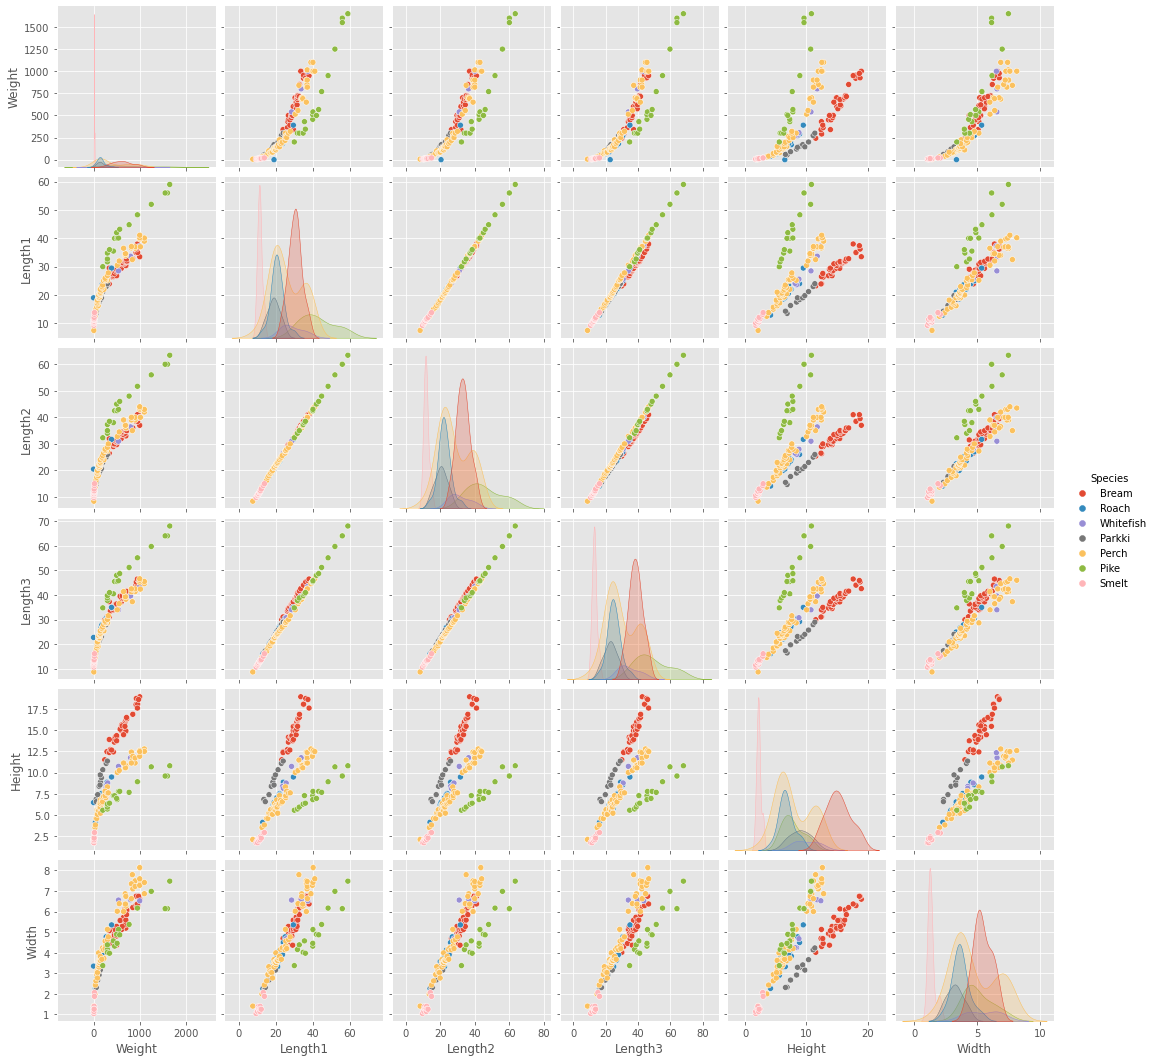

In [ ]:
sns.pairplot(df, hue="Species")

Hemos elegido de manera arbitraria el peso como nuestra variable a predecir. Podemos ver que guarda cierta correlación con otras vairables en nuestro data set. La forma en la que podemos predecir el peso de los peces puede variar.

Para efectos de simpleza para nuestro ejercicio, utilizaremos solamente la variable de longitud vertical el cual tiene un coeficiente de correlación de 0,92. Sin embargo, no podemos dejar de notar que pueden existir varios factores para entender nuestro fenómeno.

<AxesSubplot:xlabel='Length1', ylabel='Weight'>

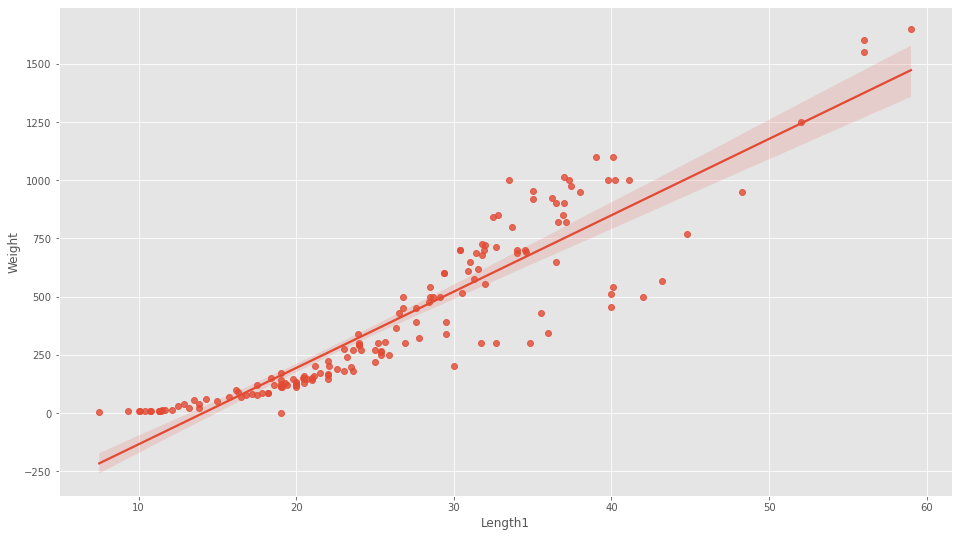

In [ ]:
sns.regplot(x=df["Length1"], y=df["Weight"])

# Modelos: Regresión Linear vs Árbol de Decisión

Ahora, entrenaremos nuestro modelo usando los módulos *Linear regression* y *Decision Tree Regressor* de Scikit-Learn. Como buena práctica, dividimos nuestro set en entrenamiento y pruebas.

Dado que usaremos una sola variable para predecir, necesitamos crear una matriz artificial con el método *reshape*.

In [ ]:
df["Length1"].values.shape

(159,)

In [ ]:
df["Length1"].values

array([23.2, 24. , 23.9, 26.3, 26.5, 26.8, 26.8, 27.6, 27.6, 28.5, 28.4,
       28.7, 29.1, 29.5, 29.4, 29.4, 30.4, 30.4, 30.9, 31. , 31.3, 31.4,
       31.5, 31.8, 31.9, 31.8, 32. , 32.7, 32.8, 33.5, 35. , 35. , 36.2,
       37.4, 38. , 12.9, 16.5, 17.5, 18.2, 18.6, 19. , 19.1, 19.4, 20.4,
       20.5, 20.5, 21. , 21.1, 22. , 22. , 22.1, 23.6, 24. , 25. , 29.5,
       23.6, 24.1, 25.6, 28.5, 33.7, 37.3, 13.5, 14.3, 16.3, 17.5, 18.4,
       19. , 19. , 19.8, 21.2, 23. , 24. ,  7.5, 12.5, 13.8, 15. , 15.7,
       16.2, 16.8, 17.2, 17.8, 18.2, 19. , 19. , 19. , 19.3, 20. , 20. ,
       20. , 20. , 20. , 20.5, 20.5, 20.7, 21. , 21.5, 22. , 22. , 22.6,
       23. , 23.5, 25. , 25.2, 25.4, 25.4, 25.4, 25.9, 26.9, 27.8, 30.5,
       32. , 32.5, 34. , 34. , 34.5, 34.6, 36.5, 36.5, 36.6, 36.9, 37. ,
       37. , 37.1, 39. , 39.8, 40.1, 40.2, 41.1, 30. , 31.7, 32.7, 34.8,
       35.5, 36. , 40. , 40. , 40.1, 42. , 43.2, 44.8, 48.3, 52. , 56. ,
       56. , 59. ,  9.3, 10. , 10.1, 10.4, 10.7, 10

In [ ]:
df["Length1"].values.reshape(-1,1).shape

(159, 1)

In [ ]:
df["Length1"].values.reshape(-1,1)

array([[23.2],
       [24. ],
       [23.9],
       [26.3],
       [26.5],
       [26.8],
       [26.8],
       [27.6],
       [27.6],
       [28.5],
       [28.4],
       [28.7],
       [29.1],
       [29.5],
       [29.4],
       [29.4],
       [30.4],
       [30.4],
       [30.9],
       [31. ],
       [31.3],
       [31.4],
       [31.5],
       [31.8],
       [31.9],
       [31.8],
       [32. ],
       [32.7],
       [32.8],
       [33.5],
       [35. ],
       [35. ],
       [36.2],
       [37.4],
       [38. ],
       [12.9],
       [16.5],
       [17.5],
       [18.2],
       [18.6],
       [19. ],
       [19.1],
       [19.4],
       [20.4],
       [20.5],
       [20.5],
       [21. ],
       [21.1],
       [22. ],
       [22. ],
       [22.1],
       [23.6],
       [24. ],
       [25. ],
       [29.5],
       [23.6],
       [24.1],
       [25.6],
       [28.5],
       [33.7],
       [37.3],
       [13.5],
       [14.3],
       [16.3],
       [17.5],
       [18.4],
       [19

In [ ]:
X = df["Length1"].values.reshape(-1,1)
y = df["Weight"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

Entrenados los modelos, podemos hacer predicciones usando el grupo de pruebas. Este nos permitirá saber que tan alejadas están nuestras predicciones.

In [ ]:
y_reg_predict = reg.predict(X_test)
y_tree_predict = tree.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_reg_predict)
ase = mean_absolute_error(y_test, y_reg_predict)

print(mse)
print(ase)

26796.684740821387
129.36788419512138


In [ ]:
mse = mean_squared_error(y_test, y_tree_predict)
ase = mean_absolute_error(y_test, y_tree_predict)

print(mse)
print(ase)

55303.05527777778
128.30624999999998


Otra forma de visualizar estos errores es graficando los residuales (resta entre valor real y valor predecido).

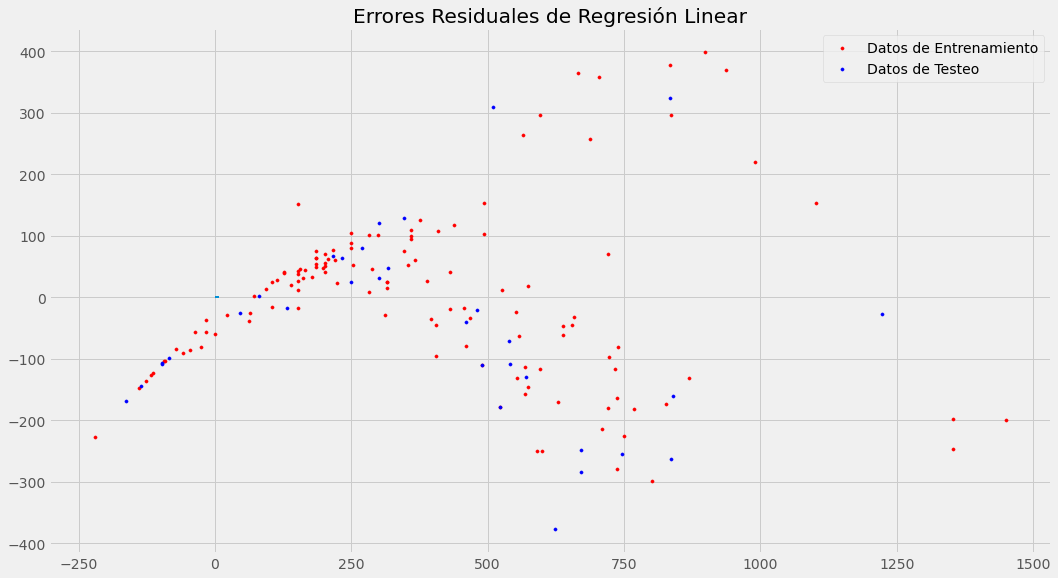

In [ ]:
plt.style.use('fivethirtyeight') 
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, 
            color = "red", s = 10, label = 'Datos de Entrenamiento')  
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Datos de Testeo')   
plt.hlines(y = 0, xmin = 0, xmax = 7, linewidth = 2)   
plt.legend(loc = 'upper right') 
plt.title("Errores Residuales de Regresión Linear") 
  
plt.show()

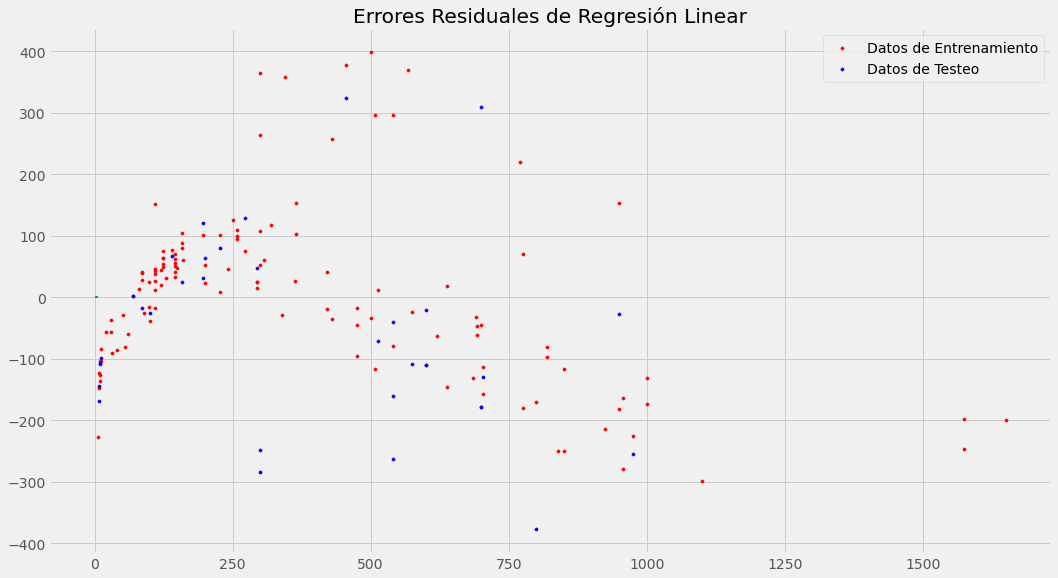

In [ ]:
plt.style.use('fivethirtyeight') 
plt.scatter(tree.predict(X_train), reg.predict(X_train) - y_train, 
            color = "red", s = 10, label = 'Datos de Entrenamiento')  
plt.scatter(tree.predict(X_test), reg.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Datos de Testeo')   
plt.hlines(y = 0, xmin = 0, xmax = 7, linewidth = 2)   
plt.legend(loc = 'upper right') 
plt.title("Errores Residuales de Regresión Linear") 
  
plt.show()

En este caso, hemos usaro el promedio de error cuadrado y error absoluto para determinar cual sería el mejor enfoque para solucionar nuestro problema. El error absoluto no nos dice mucho. Sin embargo, el error cuadrado se encuentra más alejado del 0 en el árbol de regresión. Consecuentemente, una regresión lineal simple sería más eficiente.

Pero ¿porqué? Como hemos dicho, un solo árbol de decisión es bastante malo para hacer predicciones. Por ende, necesitamos otro enfoque que veremos en los siguientes notebooks.

<a href="https://colab.research.google.com/github/XavierCarrera/Tutorial-Machine-Learning-Arboles/blob/main/3_Bagging_vs_Boosting_vs_RandomForest_Regresiones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Como vimos en el primer notebook, un árbol de regresión lineal tuvo problemas para hacer una predicción para predecir el peso de los peces. Por ende, en este ejercicio utilizamos los métodos de ensamble Bagging, AdaBoost y Random Forest para obtener un mejor desempeño.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("Fish.csv")
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


Antes de proceder al modelo, vamos a eliminar la columna de especies ya que es categórica.

In [ ]:
df.drop(["Species"], axis=1, inplace=True)
df

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936
155,13.4,11.7,12.4,13.5,2.4300,1.2690
156,12.2,12.1,13.0,13.8,2.2770,1.2558
157,19.7,13.2,14.3,15.2,2.8728,2.0672


# Entrenamiento de Modelos

Antes de proceder, vale la pena recordar cual es el estado de nuestro proyecto:

Sabemos ya que una árbol de regresión no es mejor que una regresión lineal simple. Por ende, utilizaremos tres enfoques diferentes. Cada uno crear un número adicionales de árboles y utiliza métodos distintos para resoler este problema.

* Bagging que promedia los resultados dados por los árboles. 
* Random Forest que es similar a bagging, pero que crea árboles diferentes para disminuir el error en ellos.
* Boosting que crea árboles que compensar los errores entre ellos.

Con esto en mente, vamos a entrenar nuestros modelos como de costumbre,

In [ ]:
X = df.drop(["Weight"], axis=1)
y = df["Weight"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
bagging = BaggingRegressor()
bagging.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [ ]:
boosting = AdaBoostRegressor()
boosting.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [ ]:
random = RandomForestRegressor()
random.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_bagging_predict = bagging.predict(X_test)
y_boosting_predict = boosting.predict(X_test)
y_random_predict = random.predict(X_test)

Ahora vamos a medir la precisión de nuestros modelos recordando que una regresión lineal simple nos dió un error cuadrado promedio de 26796 y un error absoluto de 129.

In [ ]:
mse = mean_squared_error(y_test, y_bagging_predict)
ase = mean_absolute_error(y_test, y_bagging_predict)

print(round(mse))
print(round(ase))

4675
47


In [ ]:
mse = mean_squared_error(y_test, y_boosting_predict)
ase = mean_absolute_error(y_test, y_boosting_predict)

print(round(mse))
print(round(ase))

7813
64


In [ ]:
mse = mean_squared_error(y_test, y_random_predict)
ase = mean_absolute_error(y_test, y_random_predict)

print(round(mse))
print(round(ase))

4377
43


En este caso, hemos visto que los tres métodos han dado mucho mejores resultados que una regresión lineal simple. Como regla general, hay que recordar que un solo árbol de decisión hace malas predicciones. Varios árboles de decisión hacen excelentes predicciones.

En este proyecto en particular, Bagging y Random Forests dieron mejor resultados. Hay que recordar que Boosting es una herramienta potente cuando lidiamos con data sets más grandes, ya que mejor exponencialmente a medida que genera más árboles de decisión.

Finalmente, podemos graficar nuevamente los residuales para ver el resultado de nuestros modelos.

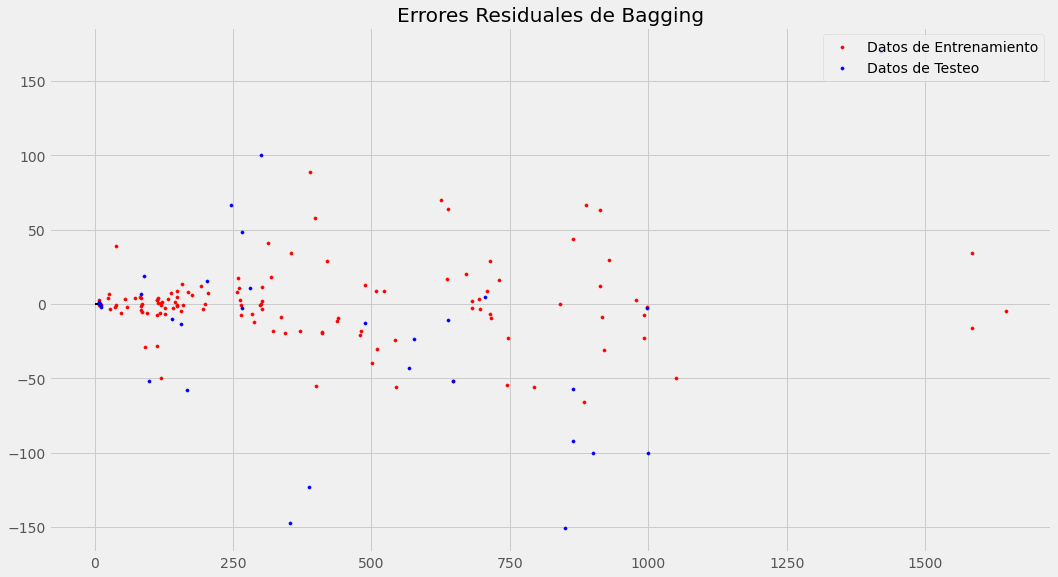

In [ ]:
plt.style.use('fivethirtyeight') 
plt.scatter(bagging.predict(X_train), bagging.predict(X_train) - y_train, 
            color = "red", s = 10, label = 'Datos de Entrenamiento')  
plt.scatter(bagging.predict(X_test), bagging.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Datos de Testeo')   
plt.hlines(y = 0, xmin = 0, xmax = 7, linewidth = 2)   
plt.legend(loc = 'upper right') 
plt.title("Errores Residuales de Bagging") 
  
plt.show()

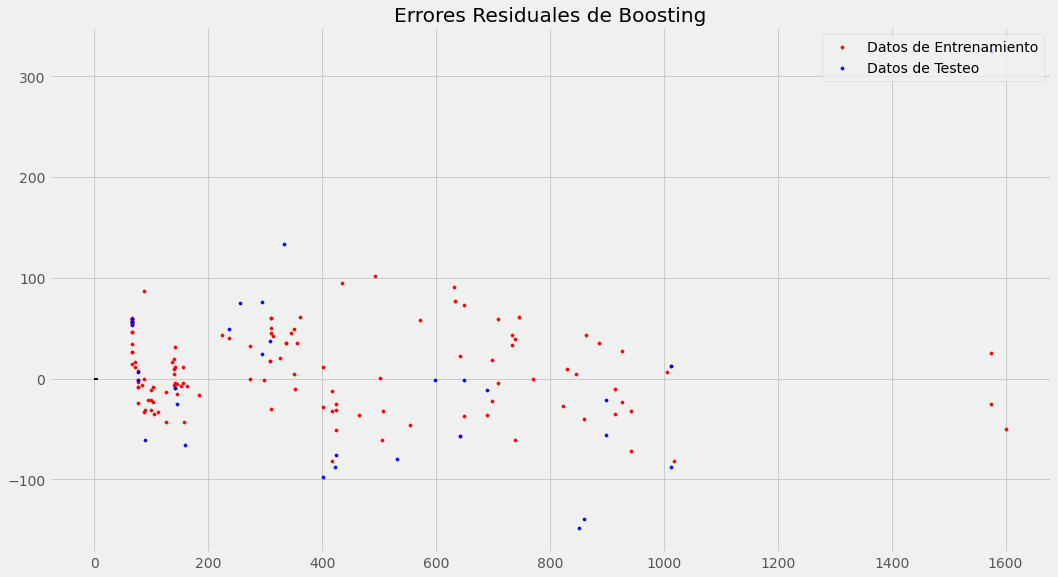

In [ ]:
plt.style.use('fivethirtyeight') 
plt.scatter(boosting.predict(X_train), boosting.predict(X_train) - y_train, 
            color = "red", s = 10, label = 'Datos de Entrenamiento')  
plt.scatter(boosting.predict(X_test), boosting.predict(X_test) - y_test, 
            color = "blue", s = 10, label = 'Datos de Testeo')   
plt.hlines(y = 0, xmin = 0, xmax = 7, linewidth = 2)   
plt.legend(loc = 'upper right') 
plt.title("Errores Residuales de Boosting") 
  
plt.show()